## Library Import

In [1]:
# データの取り扱いに関するライブラリ
import numpy as np # 高速計算
import pandas as pd # 表データの扱い

# 可視化に関するライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 自身がファイルを格納したディレクトリを指定
ROOT_DIR = '../../input/'
train_file_path = ROOT_DIR + 'train.csv'
test_file_path = ROOT_DIR + 'test.csv'
data_definition_path = ROOT_DIR + 'data_definition.xlsx'
submit_file_path = ROOT_DIR + 'submit_sample.csv'
output_path = '../../output/'

## File Import

In [112]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [67]:
data_definition = pd.ExcelFile(data_definition_path)
data_definition_df = pd.read_excel(data_definition_path, sheet_name=data_definition.sheet_names[0])

In [68]:
pk_cols = ['building_id', 'unit_id']
date_col = 'target_ym'
target_col = 'money_room'
baseline_cols = list(data_definition_df[data_definition_df['baseline_cols'] == 1]['本番データ特徴量名'])

In [72]:
print(baseline_cols)

['building_type', 'building_structure', 'floor_count', 'year_built', 'room_floor', 'bukken_type', 'flg_investment', 'addr1_1', 'addr1_2', 'walk_distance1', 'snapshot_land_area', 'house_area', 'flg_new', 'snapshot_window_angle', 'madori_number_all', 'madori_kind_all']


## EDA

#### データの分布

In [73]:
# 各データの概要を確認
display(train_df[baseline_cols].head(3))
display(test_df[baseline_cols].head(3))

,building_type,building_structure,floor_count,year_built,room_floor,bukken_type,flg_investment,addr1_1,addr1_2,walk_distance1,snapshot_land_area,house_area,flg_new,snapshot_window_angle,madori_number_all,madori_kind_all
0,4,1.0,2.0,199204.0,NaN,1202,NaN,24,205,1840.0,188.49,106.82,0.0,NaN,4,50
1,4,10.0,2.0,198108.0,NaN,1202,NaN,24,205,1920.0,290.52,134.04,0.0,NaN,4,50
2,4,1.0,2.0,199506.0,NaN,1202,NaN,24,205,2000.0,235.65,114.59,0.0,NaN,4,50


,building_type,building_structure,floor_count,year_built,room_floor,bukken_type,flg_investment,addr1_1,addr1_2,walk_distance1,snapshot_land_area,house_area,flg_new,snapshot_window_angle,madori_number_all,madori_kind_all
0,1,5.0,14.0,199510.0,4.0,1302,0.0,24,205,887.0,18093.0,70,0,5.0,3,50
1,4,1.0,2.0,199206.0,NaN,1202,NaN,24,205,880.0,197.0,171,0,NaN,6,50
2,4,10.0,2.0,197511.0,NaN,1202,NaN,23,224,2800.0,223.0,78,0,5.0,3,50


In [74]:
display(train_df[baseline_cols].info())
display(test_df[baseline_cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363924 entries, 0 to 363923
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   building_type          363924 non-null  int64  
 1   building_structure     348475 non-null  float64
 2   floor_count            362627 non-null  float64
 3   year_built             349238 non-null  float64
 4   room_floor             198452 non-null  float64
 5   bukken_type            363924 non-null  int64  
 6   flg_investment         186971 non-null  float64
 7   addr1_1                363924 non-null  int64  
 8   addr1_2                363924 non-null  int64  
 9   walk_distance1         356199 non-null  float64
 10  snapshot_land_area     173678 non-null  float64
 11  house_area             363924 non-null  float64
 12  flg_new                363922 non-null  float64
 13  snapshot_window_angle  245767 non-null  float64
 14  madori_number_all      363924 non-nu

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112437 entries, 0 to 112436
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   building_type          112437 non-null  int64  
 1   building_structure     107428 non-null  float64
 2   floor_count            112075 non-null  float64
 3   year_built             107618 non-null  float64
 4   room_floor             59523 non-null   float64
 5   bukken_type            112437 non-null  int64  
 6   flg_investment         59657 non-null   float64
 7   addr1_1                112437 non-null  int64  
 8   addr1_2                112437 non-null  int64  
 9   walk_distance1         110112 non-null  float64
 10  snapshot_land_area     55727 non-null   float64
 11  house_area             112437 non-null  int64  
 12  flg_new                112437 non-null  int64  
 13  snapshot_window_angle  76555 non-null   float64
 14  madori_number_all      112437 non-nu

None

In [29]:
display(train_df[baseline_cols].describe())
display(test_df[baseline_cols].describe())

,building_type,building_structure,floor_count,year_built,room_floor,room_count,floor_plan_code,bukken_type,flg_investment,addr1_1,addr1_2,walk_distance1,snapshot_land_area,house_area,flg_new,snapshot_window_angle,madori_number_all,madori_kind_all
count,363924.000000,348475.000000,362627.000000,349238.000000,198452.000000,316862.000000,316859.000000,363924.000000,186971.000000,363924.000000,363924.000000,356199.000000,1.736780e+05,363924.000000,363922.000000,245767.000000,363924.000000,363924.000000
mean,41.944411,3.231256,6.117669,199347.544798,5.202754,3.232246,368.902919,1256.575681,0.020870,19.961885,168.618643,1017.114531,7.161854e+02,90.369974,0.003493,4.843738,3.215479,46.193400
std,194.578871,2.072058,6.205453,1440.231090,4.249281,1.320653,133.265399,49.790260,0.143322,10.046767,56.900927,1397.271492,2.945205e+04,1501.318709,0.058994,1.376582,1.326026,9.984417
min,1.000000,0.000000,0.000000,150001.000000,-2.000000,1.000000,110.000000,1202.000000,0.000000,1.000000,101.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,1.000000,10.000000
25%,1.000000,1.000000,2.000000,198211.000000,2.000000,3.000000,320.000000,1202.000000,0.000000,13.000000,111.000000,400.000000,1.028400e+02,63.730000,0.000000,4.000000,2.000000,50.000000
50%,1.000000,4.000000,5.000000,199403.000000,4.000000,3.000000,350.000000,1302.000000,0.000000,14.000000,201.000000,720.000000,1.603600e+02,78.700000,0.000000,5.000000,3.000000,50.000000
75%,4.000000,4.000000,9.000000,200407.000000,7.000000,4.000000,450.000000,1302.000000,0.000000,27.000000,208.000000,1200.000000,2.330000e+02,101.640000,0.000000,6.000000,4.000000,50.000000
max,999.000000,12.000000,980.000000,203407.000000,58.000000,50.000000,5030.000000,1302.000000,2.000000,47.000000,621.000000,99999.000000,6.355393e+06,880084.000000,1.000000,8.000000,63.000000,99.000000


,building_type,building_structure,floor_count,year_built,room_floor,room_count,floor_plan_code,bukken_type,flg_investment,addr1_1,addr1_2,walk_distance1,snapshot_land_area,house_area,flg_new,snapshot_window_angle,madori_number_all,madori_kind_all
count,112437.000000,107428.000000,112075.000000,107618.000000,59523.000000,101048.000000,101048.000000,112437.000000,59657.000000,112437.000000,112437.000000,110112.000000,5.572700e+04,112437.000000,112437.000000,76555.000000,112437.000000,112437.000000
mean,44.950852,3.198803,6.043212,199373.707623,5.240932,3.217817,367.715838,1254.958546,0.030139,20.406379,168.624990,1037.820546,3.668409e+02,86.726923,0.002472,4.855699,3.214351,46.541975
std,201.439241,2.092509,5.532613,1493.254615,4.081418,1.368130,137.664816,49.912615,0.171461,10.176881,56.043161,1293.844805,5.196539e+03,72.777883,0.049663,1.360397,1.346485,9.697361
min,1.000000,1.000000,0.000000,186801.000000,-1.000000,1.000000,110.000000,1202.000000,0.000000,1.000000,101.000000,1.000000,0.000000e+00,9.000000,0.000000,0.000000,1.000000,10.000000
25%,1.000000,1.000000,2.000000,198209.000000,2.000000,2.000000,250.000000,1202.000000,0.000000,13.000000,111.000000,400.000000,1.000000e+02,63.000000,0.000000,4.000000,2.000000,50.000000
50%,1.000000,4.000000,4.000000,199403.000000,4.000000,3.000000,350.000000,1302.000000,0.000000,15.000000,201.000000,720.000000,1.570000e+02,78.000000,0.000000,5.000000,3.000000,50.000000
75%,4.000000,4.000000,9.000000,200411.000000,7.000000,4.000000,450.000000,1302.000000,0.000000,27.000000,208.000000,1280.000000,2.290000e+02,102.000000,0.000000,6.000000,4.000000,50.000000
max,999.000000,12.000000,62.000000,220211.000000,53.000000,77.000000,7730.000000,1302.000000,2.000000,47.000000,621.000000,99999.000000,1.020833e+06,12105.000000,1.000000,8.000000,44.000000,99.000000


#### 目的変数の分布

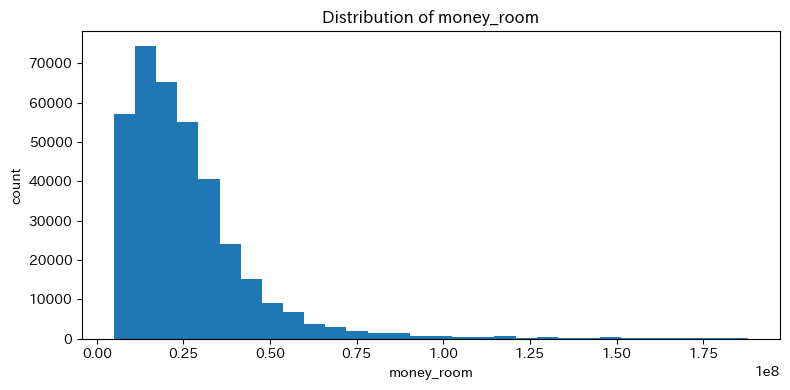

In [32]:
plt.figure(figsize=(8,4))
plt.hist(train_df[target_col], bins=30)
plt.xlabel("money_room")
plt.ylabel("count")
plt.title("Distribution of money_room")
plt.tight_layout()
plt.show()


#### 説明変数の分布

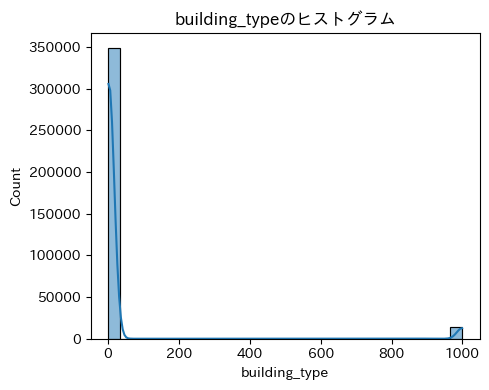

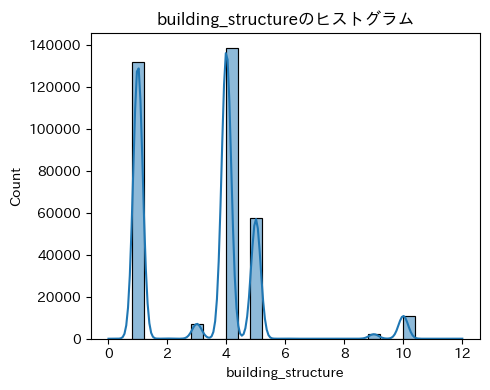

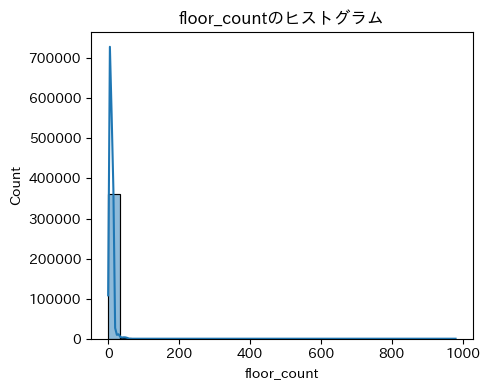

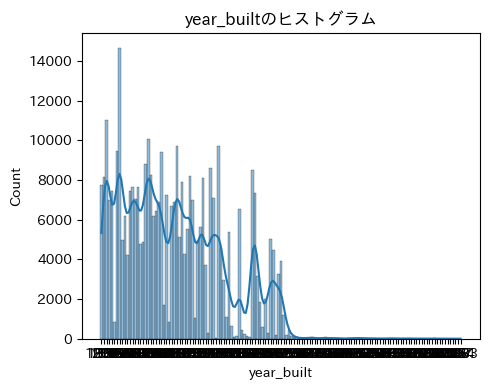

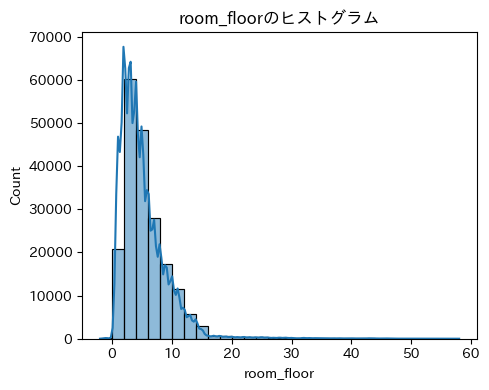

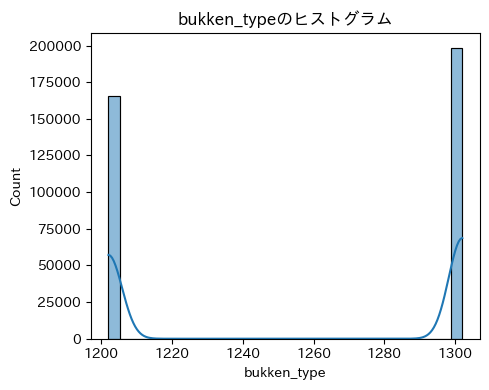

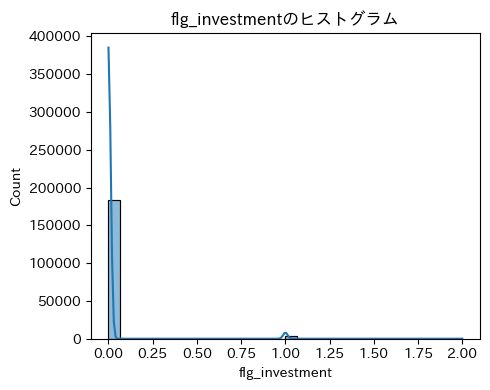

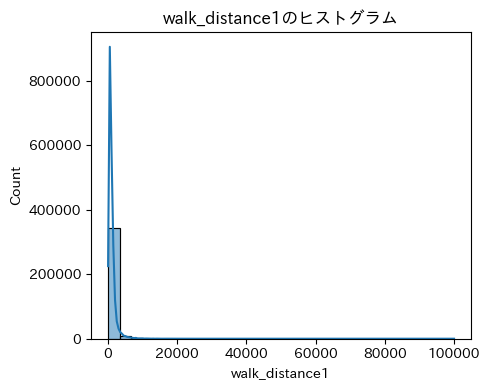

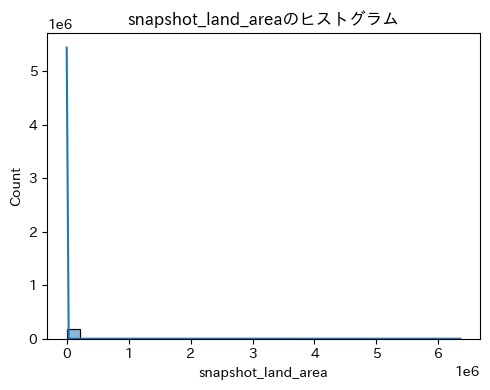

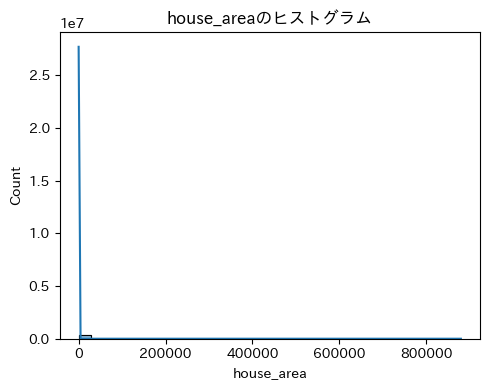

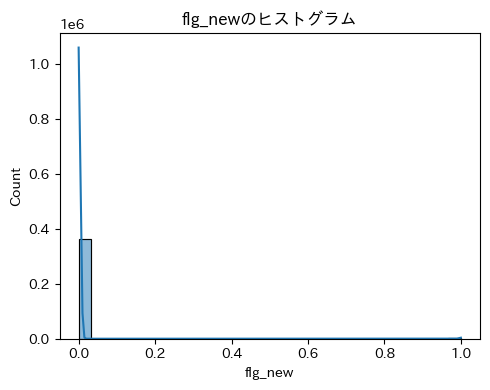

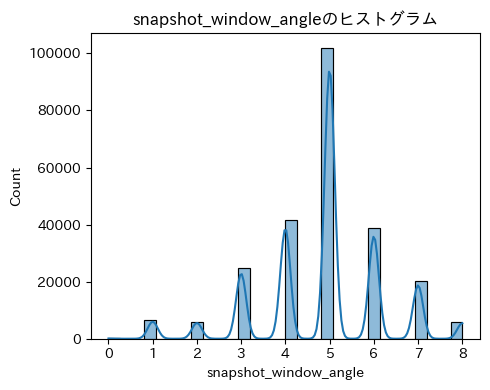

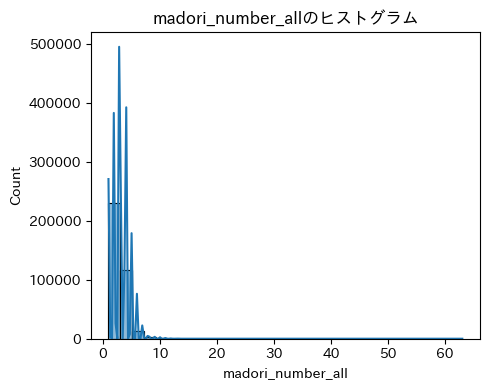

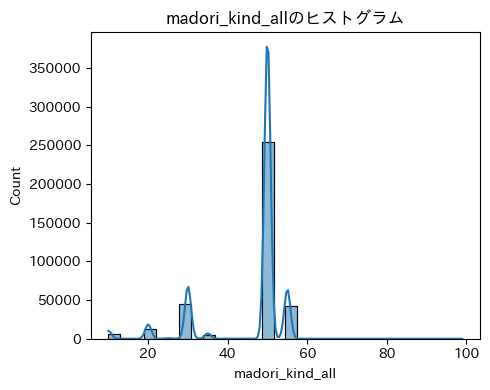

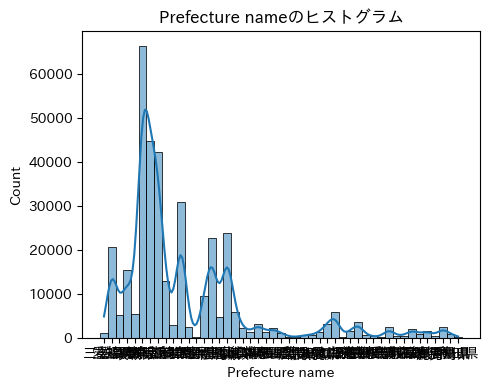

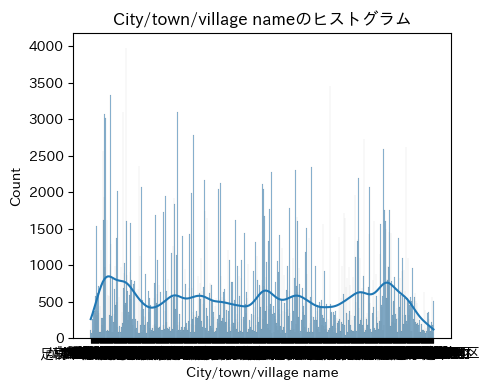

In [91]:
# 数値型はヒストグラムで可視化
for col in baseline_cols:
    plt.figure(figsize=(5, 4))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f"{col}のヒストグラム")
    plt.tight_layout()
    plt.show()

#### 説明変数と目的変数の関係

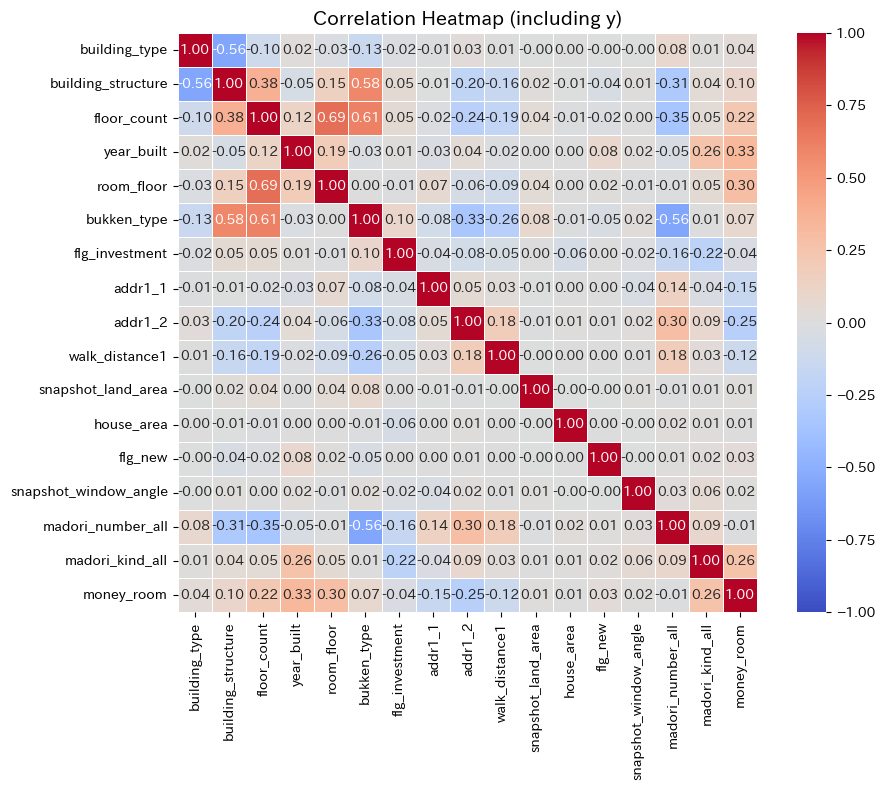

In [75]:
# --- 相関行列 ---
cols = baseline_cols + [target_col]
corr = train_df[cols].corr()

# --- ヒートマップ ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,        # セルに相関係数を表示（不要なら False）
    fmt=".2f",
    cmap="coolwarm",   # カラースケール
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)

plt.title("Correlation Heatmap (including y)", fontsize=14)
plt.tight_layout()
plt.show()

## 前処理

#### アドレス情報の置換

In [76]:
codes = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[3])
codes.columns = ['No.', 'addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']
codes = codes[['addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']]

train_df = pd.merge(train_df, codes, on=['addr1_1', 'addr1_2'], how='inner')
test_df = pd.merge(test_df, codes, on=['addr1_1', 'addr1_2'], how='inner')

In [77]:
train_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
test_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
del codes

In [78]:
# 追加する特徴量
add_cols = ['Prefecture name', 'City/town/village name']

# 削除する特徴量
remove_cols = ['addr1_1', 'addr1_2']

# --- 加工 ---
# 追加
baseline_cols = baseline_cols + add_cols

# 削除
baseline_cols = [c for c in baseline_cols if c not in remove_cols]

In [79]:
train_df[['Prefecture name', 'City/town/village name']].sample(3, random_state=2025)

,Prefecture name,City/town/village name
48171,埼玉県,川越市
16175,大阪府,堺市美原区
286956,北海道,札幌市南区


#### 築年数の置換

In [80]:
def parse_year(date_input):
    try:
        date_input = str(date_input)
        return date_input[:4]           
    except Exception as e:
        return str(date_input)

In [81]:
train_df["year_built"] = train_df["year_built"].apply(parse_year)
test_df["year_built"] = test_df["year_built"].apply(parse_year)

In [82]:
train_df["year_built"].sample(3)

183786    2009
81400     1969
282677    1981
Name: year_built, dtype: object

#### 異常値の置換

In [ ]:
# 最高階は62階なのでいったん大丈夫？

#### 欠損値補完

In [90]:
train_df[baseline_cols].describe()

,building_type,building_structure,floor_count,room_floor,bukken_type,flg_investment,walk_distance1,snapshot_land_area,house_area,flg_new,snapshot_window_angle,madori_number_all,madori_kind_all
count,363924.000000,348475.000000,362627.000000,198452.000000,363924.000000,186971.000000,356199.000000,1.736780e+05,363924.000000,363922.000000,245767.000000,363924.000000,363924.000000
mean,41.944411,3.231256,6.117669,5.202754,1256.575681,0.020870,1017.114531,7.161854e+02,90.369974,0.003493,4.843738,3.215479,46.193400
std,194.578871,2.072058,6.205453,4.249281,49.790260,0.143322,1397.271492,2.945205e+04,1501.318709,0.058994,1.376582,1.326026,9.984417
min,1.000000,0.000000,0.000000,-2.000000,1202.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,1.000000,10.000000
25%,1.000000,1.000000,2.000000,2.000000,1202.000000,0.000000,400.000000,1.028400e+02,63.730000,0.000000,4.000000,2.000000,50.000000
50%,1.000000,4.000000,5.000000,4.000000,1302.000000,0.000000,720.000000,1.603600e+02,78.700000,0.000000,5.000000,3.000000,50.000000
75%,4.000000,4.000000,9.000000,7.000000,1302.000000,0.000000,1200.000000,2.330000e+02,101.640000,0.000000,6.000000,4.000000,50.000000
max,999.000000,12.000000,980.000000,58.000000,1302.000000,2.000000,99999.000000,6.355393e+06,880084.000000,1.000000,8.000000,63.000000,99.000000


In [113]:
# 階数
train_df['floor_count_filled'] = (
    train_df.groupby('building_id')['floor_count']
            .transform('max')
)

train_df['floor_count'] = train_df['floor_count_filled'].where(
    train_df['floor_count_filled'] <= 62
)

In [114]:
train_df['building_type_filled'] = (
    train_df.groupby('building_id')['building_type']
            .transform('max')
)

# train_df['building_type'] = np.where(
#     train_df['floor_count'] <= 2,                      # 条件1：階数が2以下なら
#     3,                                                 # building_type = 3
#     train_df['building_type_filled'].where(            # それ以外は条件2へ
#         train_df['building_type_filled'].isin([1, 3])  # 1 or 3 の場合はそのまま
#     )
# )

In [117]:
train_df[['building_type_filled', 'bukken_type']].drop_duplicates()

,building_type_filled,bukken_type
0,4,1202
4,1,1302
7,999,1202
222,8,1302
448,999,1302
462,3,1202
948,901,1302
2253,15,1202
2322,5,1202
2499,9,1202


In [111]:
train_df['building_type'].value_counts(dropna=False)

building_type
1.0    194328
3.0    145251
NaN     24345
Name: count, dtype: int64

## ベースラインの仮説

- 推測したいのは不動産価格（対数変換する）
- 自分が物件を探す時に考えること
    - エリア
        - 都心かどうか
        - （都心の場合、最寄り駅からどのくらい近いか）
    - 建物自体
        - マンションかアパートか
        - 木造かRCか、など建物の構造
        - 築年数
    - 物件
        - 間取り
        - 階数
        - 広さ
        - （物件のタグ情報は見ておきたい）
        - 部屋向き
        - 新築か中古か
